# Gene Expression Analysis Pipeline
This notebook processes gene expression data to identify the top genes that differ most consistently from control means across multiple studies. It then visualizes these differences using PCA.

## My ChatGPT prompt
The code was mostly generated by ChatGPT's Data Analyst model. Below is the prompt that I started with:

> I have multiple studies with gene expression data. Each Study has one or more families/species under study, indicated by the column 'BREED'. Some samples (indicated by the column 'Experiment'), are Controls, and others are treatments, indicated by the Boolean-valued column 'Control'.

> For each sample, use expression counts per million, and filter out genes where CPM < 10 across all samples.

> Exclude the Study named Johnson et al. 2020.

> Within each BREED within each Study, for each gene_id, find the mean and variance of the expression values of the Control samples. So for each BREED, you'll have mean and variance values for the Control samples. Let's call this control_stats_per_breed.
> And then for each non-Control sample within each BREED within each Study, for each gene_id, subtract the gene count from the control_stats_per_breed mean to arrive at difference_from_control_mean for that sample and gene_id.

> I now want to take the top 5000 genes that differ most consistently (with the constraint of statistical significance considering variance) including sign (no absolute values) from their respective control_stats_per_breed means across all Studies. Use a variable for 5000 so that it can be easily changed.

> Report on how you evaluate that statistical significance and give me a sense of the quality of the consistency across Studies for these 5000 genes.

> Perform PCA on these gene-level differences to visualize patterns across studies and families.
> I will provide a gene expression matrix and metadata. Please help me process the data in a memory-efficient way, considering that the dataset may be large.

# Gene Expression Meta-Analysis: Study-Wide Standardization & PCA

## Steps:
1. Load and preprocess data
2. Compute control statistics
3. Compute differences from control means
4. Perform statistical tests and select top genes
5. Perform PCA and visualize results

### **Load Data**
We first load the metadata and gene expression matrix.

In [2]:
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_1samp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load metadata and gene expression data
working_dir = "~/git/Cvirg_Pmarinus_RNAseq/data/"
# === 1️⃣ Load Expression Data (TSV) ===
expression_file = os.path.join(working_dir, "rnaseq_gene_counts", "merged_gene_counts.tsv")
gene_counts = pd.read_csv(expression_file, sep="\t", index_col=0)

# Load the metadata file
metadata_file_path = os.path.join(working_dir, "augmented_metadata.csv")
metadata = pd.read_csv(metadata_file_path)
print (metadata.shape)



(217, 12)


### **Data Preprocessing**
- Start with a **gene expression matrix (CPM - counts per million)**.
- **Filter out genes where CPM < 10 across all samples**.
- **Exclude the study *Johnson et al. 2020***.


In [3]:
# Compute Counts Per Million (CPM)
library_sizes = gene_counts.sum(axis=0)
cpm = (gene_counts / library_sizes) * 1e6

# Filter out genes with CPM < 10 across all samples
filtered_genes = cpm[(cpm >= 10).any(axis=1)]

# Exclude 'Johnson et al. 2020'
excluded_study = 'Johnson et al. 2020'
samples_to_exclude = metadata[metadata['Study'] == excluded_study]['Experiment'].tolist()

filtered_metadata = metadata[~metadata['Experiment'].isin(samples_to_exclude)]
filtered_gene_counts = filtered_genes.drop(columns=samples_to_exclude, errors='ignore')

### **Compute Control Statistics (`control_stats_per_breed`)**
- Within each **Study** and **BREED**, compute:
  - **Mean expression** of control samples per gene.
  - **Variance of expression** of control samples per gene.
- Store these statistics as `control_stats_per_breed`, which will serve as the baseline for comparisons.

[Up to 6 minutes on laptop]


In [4]:
sample_to_breed_study = filtered_metadata.set_index('Experiment')[['Study', 'BREED', 'control']]
control_samples = sample_to_breed_study[sample_to_breed_study['control'] == 1].index

# Compute mean and variance for control samples
control_stats_per_breed = (
    filtered_gene_counts[control_samples]
    .T.join(sample_to_breed_study, how='left')
    .groupby(['Study', 'BREED'])
    .agg(['mean', 'var'])
)
control_stats_per_breed = control_stats_per_breed.swaplevel(axis=1)
control_stats_per_breed.describe()
print(f"Genes with 'var' values: {(control_stats_per_breed.xs('var', level=0, axis=1).count() > 0).sum()}")
print("Shape of control_stats_per_breed:", control_stats_per_breed.shape)



Genes with 'var' values: 26077
Shape of control_stats_per_breed: (9, 52154)


## Overview
Compute standardized differences between experimental (non-control) samples and control samples.
Account for variability in control samples using a Bayesian shrinkage approach.
Separate tolerant and sensitive groups.

## Key Steps

1. **Compute Differences from Control Mean:**
   - Identifies non-control samples.
   - Groups them by study and breed.
   - Computes the difference between each sample’s gene expression and the control mean for the corresponding study and breed.

2. **Standard Deviation Adjustment Using Shrinkage:**
   - Computes the standard deviation of control samples.
   - Applies a shrinkage technique to stabilize variance estimates due to small control sample sizes.
   - Uses a global median standard deviation to avoid division by small variance values.
   - Adjusts values below a threshold (experimentally determined as 0.07).

3. **Calculate Standardized Effect Size:**
   - Converts raw differences into __standardized differences__ by dividing them by the adjusted control standard deviation.

4. **Group Samples by Trait (Tolerant vs. Sensitive):**
   - Separates standardized differences into two groups (tolerant vs. sensitive) for further downstream analysis.


Genes with at least one non-null value: 26076
global_std: Study             BREED                   
Chan et al. 2021  Crassostrea gigas           3.250931
                  Crassostrea virginica       2.327833
P&S 2020          ABC_VIMS_Family_2014_242    4.589701
                  ABC_VIMS_Family_2014_266    4.829261
P&S 2021          ABC_VIMS_Family_2014_286    5.030704
P&S 2023          ABC_VIMS_Family_2017084     3.158108
                  ABC_VIMS_Family_2017089     2.053652
                  ABC_VIMS_Family_2017090     1.720959
                  ABC_VIMS_Family_2017120     2.273810
dtype: float64
Smallest nonzero control standard deviation (after fix): 0.07002816311157826
Number of overlapping genes: 26077 (expected: 26077)
Shape of standardized_differences: (26077, 109) (expected: same as differences_df)
Max standardized difference: 21491.115041423673
Min standardized difference: -319.7680804669657
Mean absolute standardized difference: 2.0975809175850957


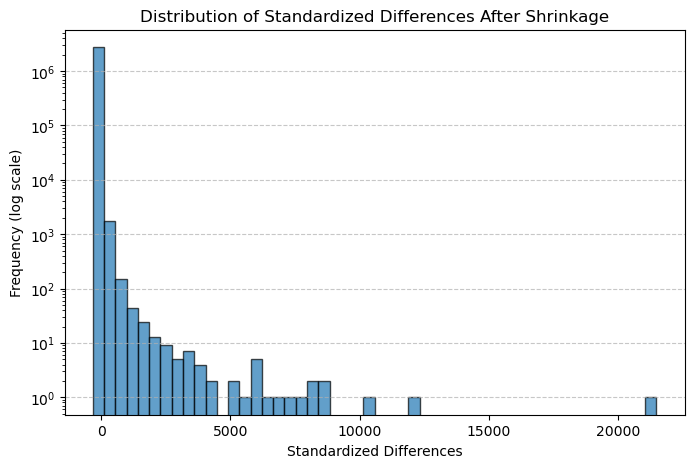

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, combine_pvalues

differences = []
non_control_samples = sample_to_breed_study[sample_to_breed_study['control'] == 0].index

for (study, breed), group in sample_to_breed_study.loc[non_control_samples].groupby(['Study', 'BREED']):
    if (study, breed) in control_stats_per_breed.index:
        control_means = control_stats_per_breed.loc[(study, breed)]['mean']
        samples = group.index
        subset = filtered_gene_counts.loc[:, samples]
        difference_from_control_mean = subset.sub(control_means, axis=0)
        differences.append(difference_from_control_mean)


differences_df = pd.concat(differences, axis=1)
print(f"Genes with at least one non-null value: {(differences_df.count(axis=1) > 0).sum()}")

# Compute control standard deviation
control_variance = control_stats_per_breed.xs("var", level=0, axis=1)
control_std = np.sqrt(control_variance.replace(0, np.nan))
control_std = control_std.T  # Transpose so genes become rows

aligned_control_std = control_std.copy()

# Because we have few control samples per family (min 3), raw variance will be unstable.
# So we use median global standard deviation to avoid dividing by extremely small variance values.
# ChatGPT called this "Bayesian Shrinkage for Variance"
shrink_factor = 0.5  # Adjust to control shrinkage level
global_std = control_std[control_std > 0].median()  
print (f"global_std: {global_std}")

# Define a threshold to replace very small values
threshold = 0.07  # Values below this will be adjusted. 0.07 was arrived at by experimentation

# Expand global_std to match aligned_control_std (26077 genes, 9 BREEDs)
shrink_values = pd.DataFrame(np.tile(global_std.values, (aligned_control_std.shape[0], 1)),
                             index=aligned_control_std.index,
                             columns=aligned_control_std.columns) * shrink_factor

# Apply mask
aligned_control_std = aligned_control_std.mask(aligned_control_std < threshold, shrink_values)

# Debugging: Check new min standard deviation
print("Smallest nonzero control standard deviation (after fix): " +
      f"{aligned_control_std[aligned_control_std > 0].min().min()}")

# Compute standardized effect size
differences_df = differences_df.astype(np.float32)  # Ensure memory efficiency
common_genes = differences_df.index.intersection(aligned_control_std.index)
print(f"Number of overlapping genes: {len(common_genes)} (expected: {differences_df.shape[0]})")

# Map each sample to its BREED
breed_mapping = filtered_metadata.set_index("Experiment")["BREED"]

# Expand aligned_control_std to match sample structure
sample_breeds = filtered_metadata.set_index("Experiment")[["Study", "BREED"]]  # Keep Study and BREED
sample_breeds = sample_breeds.reindex(differences_df.columns)  # Align with sample order

# Convert DataFrame rows into a list of tuples
sample_breeds_tuples = list(map(tuple, sample_breeds.values))
# Create MultiIndex
sample_breeds_index = pd.MultiIndex.from_tuples(sample_breeds_tuples, names=["Study", "BREED"])

differences_df.index.name = "gene_id"
aligned_control_std.index.name = "gene_id"

# Reindex using the full MultiIndex
expanded_control_std = aligned_control_std.reindex(columns=sample_breeds_index, fill_value=np.nan)

# Compute **standarized differences**: differences divided by respective standard deviations
standardized_differences = differences_df.div(expanded_control_std.values)

# Split data into tolerant and sensitive groups
tolerant_samples = filtered_metadata[filtered_metadata["Trait"] == "tolerant"]["Experiment"]
sensitive_samples = filtered_metadata[filtered_metadata["Trait"] == "sensitive"]["Experiment"]
valid_tolerant_samples = tolerant_samples[tolerant_samples.isin(standardized_differences.columns)]
valid_sensitive_samples = sensitive_samples[sensitive_samples.isin(standardized_differences.columns)]

# Debugging: Check standardized differences shape
print(f"Shape of standardized_differences: {standardized_differences.shape} (expected: same as differences_df)")
print("Max standardized difference:", standardized_differences.max().max())
print("Min standardized difference:", standardized_differences.min().min())
print("Mean absolute standardized difference:", standardized_differences.abs().mean().mean())

# Plot a histogram of standardized differences to visualize distribution
plt.figure(figsize=(8, 5))
plt.hist(standardized_differences.values.flatten(), bins=50, edgecolor="black", alpha=0.7)
plt.yscale("log")  # Use log scale to better visualize extreme values
plt.xlabel("Standardized Differences")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Standardized Differences After Shrinkage")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Separate standardized differences for tolerant and sensitive samples
standardized_differences_tolerant = standardized_differences[valid_tolerant_samples]
standardized_differences_sensitive = standardized_differences[valid_sensitive_samples]



### **Select the Top 5000 Most Consistently Deviant Genes**
- **Meta-analyze across studies** to determine which genes **deviate most consistently** from their control means, separately for the tolerant and sensitive samples.
- **Use `I²` (I-squared)** to measure **heterogeneity** (variation across studies).
- **Select genes based on:**
  - **P-value (`combined_p_value < threshold`)** → Statistical significance.
  - **I² (`I_squared < threshold`)** → Consistency across studies.
  - **Sort genes by lowest `combined_p_value` and pick the top 5000**.

Note: In development of this script, before applying Bayesian shrinking and thresholding, `weighted_mean`, `Q_stat`, and `I_squared` were initially all nearly entirely zero.

In [ ]:

# Group data by Study
# study_groups = list(standardized_differences.T.groupby(filtered_metadata.set_index("Experiment")["Study"]))
study_groups = []
for study, study_df in filtered_metadata.groupby("Study"):
    matching_samples = study_df["Experiment"].values  # Get sample IDs
    valid_samples = [s for s in matching_samples if s in standardized_differences.columns]  # Filter only valid samples
    study_data = standardized_differences[valid_samples]  # Select samples as columns
    if not study_data.empty:
        study_groups.append((study, study_data))

print(f"Total study groups: {len(study_groups)}")
for study, df in study_groups[:5]:  # First 5 studies
    print(f"Study: {study} | Shape: {df.shape} | First 5 columns (samples): {df.columns[:5].tolist()}")

# Compute meta-analysis statistics for each gene

# Function to compute effect size and heterogeneity per gene
import numpy as np
from scipy.stats import ttest_1samp, combine_pvalues

def meta_analysis_per_gene(gene_id, study_groups):
    epsilon = 1e-6  # Small constant to avoid zero variance issues

    effect_sizes = []
    variances = []
    p_values = []

    # Iterate over study_groups, which is a list of tuples (study, df)
    for study, df in study_groups:  
        if gene_id in df.index:
            values = df.loc[gene_id].dropna().values  # Extract non-null values
            if len(values) > 1:  
                t_stat, p_val = ttest_1samp(values, 0, nan_policy="omit")
                mean_effect = np.mean(values)
                var_effect = np.var(values, ddof=1)  

                effect_sizes.append(mean_effect)
                variances.append(var_effect)
                p_values.append(p_val)

    # If not enough studies, return NaN
    if len(effect_sizes) < 2:
        return np.nan, np.nan, np.nan, np.nan

    # Convert to numpy arrays
    effect_sizes = np.array(effect_sizes)
    variances = np.array(variances)
    p_values = np.array(p_values)

    if np.all(np.isclose(effect_sizes, effect_sizes[0])):
        print ("effect sizes nearly identical")
        return np.nan, np.nan, np.nan, np.nan  # Skip unstable genes

    # **Compute mean variance across studies for this gene**
    # **Apply variance clipping here**
    clipped_variance_min = 1e-3  # Maximum allowed variance
    variances = np.clip(variances, clipped_variance_min, None)

    variance_mean = np.mean(variances)

    # Compute weights using the clipped variance_mean
    weights = 1 / variance_mean

    # Compute weighted mean effect size
    weighted_mean = np.sum(weights * np.array(effect_sizes)) / np.sum(weights)

    # Compute Cochran's Q-statistic for heterogeneity
    Q_stat = np.sum(weights * (np.array(effect_sizes) - weighted_mean) ** 2)

    # Compute I² heterogeneity measure
    I_squared = max(0, (Q_stat - (len(effect_sizes) - 1)) / (Q_stat + 1e-6)) * 100 if Q_stat > 0 else 0

    # Clip p-values to prevent log(0) issues
    p_values = np.clip(p_values, 1e-15, 1)

    # Combine p-values using Fisher’s method
    combined_p_value = combine_pvalues(p_values)[1] if len(p_values) > 1 else p_values[0]

    return weighted_mean, Q_stat, I_squared, combined_p_value, variances

study_groups_tolerant = [
    (study, df[df.columns.intersection(valid_tolerant_samples)])
    for study, df in study_groups if not df[df.columns.intersection(valid_tolerant_samples)].empty
]

# Filter study groups to contain only sensitive samples
study_groups_sensitive = [
    (study, df[df.columns.intersection(valid_sensitive_samples)])
    for study, df in study_groups if not df[df.columns.intersection(valid_sensitive_samples)].empty
]
# Meta-analysis per gene for tolerant samples
meta_results_tolerant = {
    gene: meta_analysis_per_gene(gene, study_groups_tolerant)
    for gene in standardized_differences_tolerant.index
}

# Meta-analysis per gene for sensitive samples
meta_results_sensitive = {
    gene: meta_analysis_per_gene(gene, study_groups_sensitive)
    for gene in standardized_differences_sensitive.index
}


Total study groups: 4
Study: Chan et al. 2021 | Shape: (26077, 4) | First 5 columns (samples): ['SRX13037868', 'SRX13037867', 'SRX13037863', 'SRX13037862']
Study: P&S 2020 | Shape: (26077, 30) | First 5 columns (samples): ['SRX7172559', 'SRX7172553', 'SRX7172552', 'SRX7172524', 'SRX7172558']
Study: P&S 2021 | Shape: (26077, 26) | First 5 columns (samples): ['SRX9845543', 'SRX9845542', 'SRX9845541', 'SRX9845540', 'SRX9845511']
Study: P&S 2023 | Shape: (26077, 49) | First 5 columns (samples): ['SRX18040064', 'SRX18040062', 'SRX18040061', 'SRX18040060', 'SRX18040059']


/home/syost/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ValueError: 4 columns passed, passed data had 5 columns

In [9]:

# Convert to DataFrame
meta_df_tolerant = pd.DataFrame.from_dict(meta_results_tolerant, orient="index",
                                          columns=["weighted_mean", "Q_stat", "I_squared", "combined_p_value", "variances"])
meta_df_sensitive = pd.DataFrame.from_dict(meta_results_sensitive, orient="index",
                                           columns=["weighted_mean", "Q_stat", "I_squared", "combined_p_value", "variances"])


# Debugging: Check meta-analysis DataFrame shape
print(f"Shape of meta_df_tolerant: {meta_df_tolerant.shape} (expected: (n_genes, 5))")
print(f"Shape of meta_df_sensitive: {meta_df_sensitive.shape} (expected: (n_genes, 5))")


Shape of meta_df_tolerant: (26077, 5) (expected: (n_genes, 5))
Shape of meta_df_sensitive: (26077, 5) (expected: (n_genes, 5))


Summary statistics for meta_df:
       weighted_mean        Q_stat     I_squared  combined_p_value  \
count   25929.000000  25929.000000  25929.000000      2.592900e+04   
mean        1.528223     11.374881     37.193412      9.370665e-02   
std        16.606155     38.797314     36.449537      1.888255e-01   
min      -143.186096      0.000533      0.000000      4.491731e-55   
25%        -1.672194      1.515792      0.000000      6.276224e-06   
50%         0.104605      4.331380     31.772109      3.353578e-03   
75%         2.405493     11.354436     73.902598      7.862679e-02   
max      1714.747648   3656.043103     99.945296      9.988377e-01   

       variance_mean  variance_max  variance_min   num_studies  
count   2.592900e+04  2.592900e+04  25929.000000  26077.000000  
mean    7.903027e+02  2.734601e+03      0.321319      3.906124  
std     4.612487e+04  1.500099e+05      0.409983      0.419561  
min     1.000000e-03  1.000000e-03      0.001000      0.000000  
25%     1.24

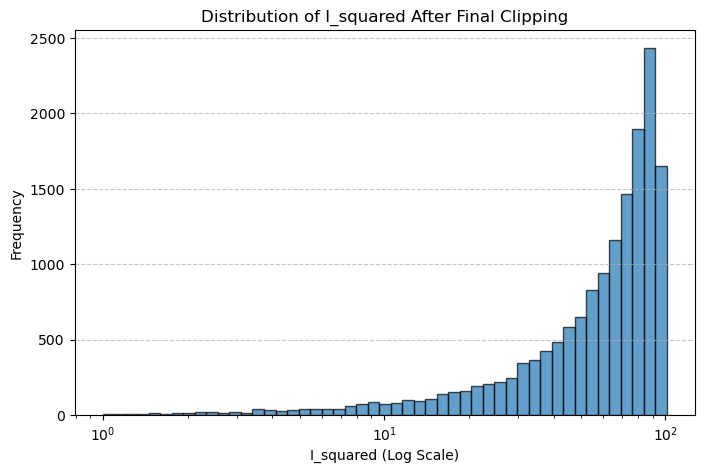

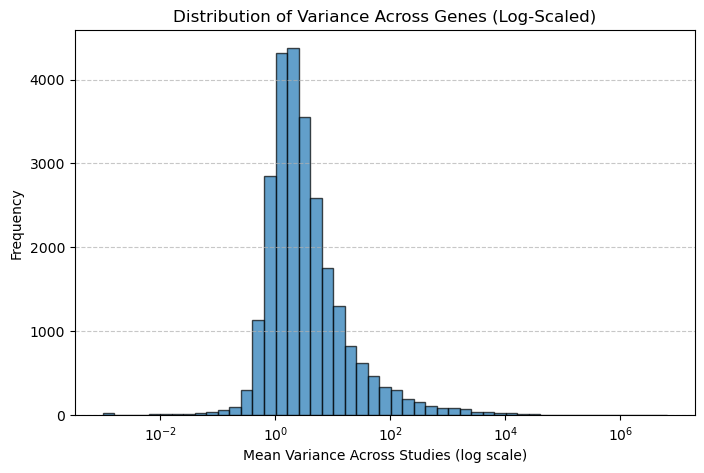

Summary statistics for meta_df:
       weighted_mean        Q_stat     I_squared  combined_p_value  \
count   25874.000000  25874.000000  25874.000000      2.587400e+04   
mean        0.661286      8.738091     30.254133      8.457423e-02   
std         6.895086     36.082728     35.427080      1.824643e-01   
min       -82.004161      0.000012      0.000000      3.743059e-50   
25%        -1.369618      1.011056      0.000000      7.714968e-07   
50%        -0.063233      2.819150      3.815441      1.504925e-03   
75%         1.469686      8.368435     66.022391      6.199260e-02   
max       381.051173   2662.465768     99.924898      9.993517e-01   

       variance_mean  variance_max  variance_min   num_studies  
count   25874.000000  2.587400e+04  25874.000000  26077.000000  
mean      169.331551  5.610331e+02      0.342267      3.687234  
std      6470.249175  2.277544e+04      1.152166      0.586415  
min         0.001000  1.000000e-03      0.001000      0.000000  
25%         

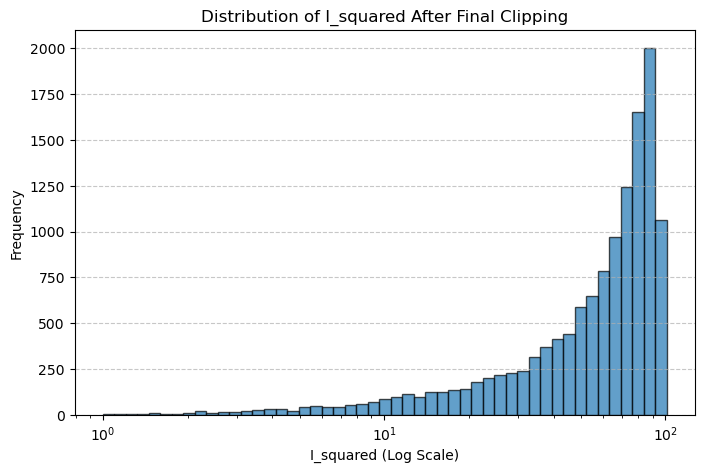

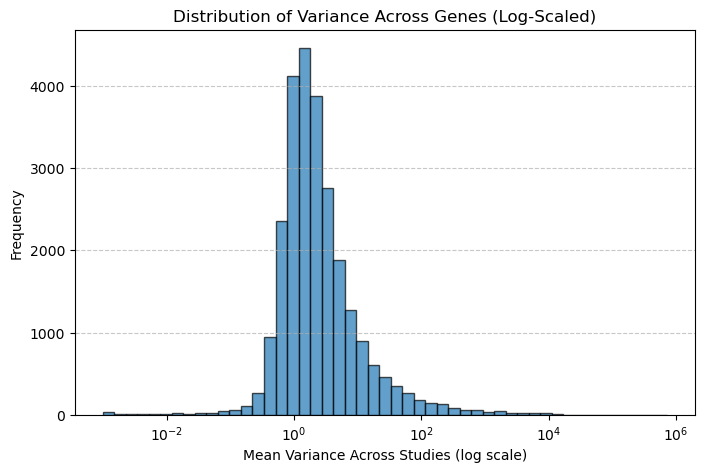

In [10]:
for meta_df in (meta_df_sensitive, meta_df_tolerant):
    # Expand variances column (which is currently a list per gene)
    meta_df["variance_mean"] = meta_df["variances"].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
    meta_df["variance_max"] = meta_df["variances"].apply(lambda x: np.max(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
    meta_df["variance_min"] = meta_df["variances"].apply(lambda x: np.min(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else np.nan)
    meta_df["num_studies"] = meta_df["variances"].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)

    # Drop the original list column (optional)
    # meta_df.drop(columns=["variances"], inplace=True)

    print("Summary statistics for meta_df:")
    print(meta_df.describe())
    print(meta_df.head(5))

    # Reclip `Q_stat` to prevent runaway values
    # Further clip Q_stat to prevent excessive values
    print("Pre-clip Q_stat summary:\n", meta_df["Q_stat"].describe())
    meta_df["Q_stat"] = np.clip(meta_df["Q_stat"], 0, 1e4)
    # Debugging: Check new minimum variance
    print("Updated Q_stat summary:\n", meta_df["Q_stat"].describe())

    # Recompute I_squared using the updated Q_stat
    meta_df["I_squared"] = np.where(
        meta_df["Q_stat"] > 0,
        np.maximum(0, (meta_df["Q_stat"] - (meta_df["num_studies"] - 1)) / (meta_df["Q_stat"] + 1e-6)) * 100,
        0
    )

    # Show updated I_squared summary
    print("Updated I_squared summary:\n", meta_df["I_squared"].describe())

    # Plot I_squared histogram to confirm improvements
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(8, 5))
    plt.hist(meta_df["I_squared"].dropna(),
            bins=np.logspace(np.log10(meta_df["I_squared"].min() + 1),
                            np.log10(meta_df["I_squared"].max() + 1), 50),
                            edgecolor="black", alpha=0.7)
    plt.xscale("log")  # Log scale for better visualization
    plt.xlabel("I_squared (Log Scale)")
    plt.ylabel("Frequency")
    plt.title("Distribution of I_squared After Final Clipping")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    import matplotlib.pyplot as plt
    # Drop zero and near-zero values to avoid log issues
    filtered_variances = meta_df["variance_mean"].replace(0, np.nan).dropna()

    # Plot histogram with log scale
    plt.figure(figsize=(8, 5))
    plt.hist(filtered_variances, bins=np.logspace(np.log10(filtered_variances.min()), np.log10(filtered_variances.max()), 50), edgecolor="black", alpha=0.7)
    plt.xscale("log")  # Use log scale on x-axis
    plt.xlabel("Mean Variance Across Studies (log scale)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Variance Across Genes (Log-Scaled)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

### Filtering

In [11]:

# Apply filters: select genes with significant deviation AND reasonable heterogeneity
# Step 1: Select top 5000 genes with the **largest absolute deviation** from control mean
top_genes = meta_df.reindex(meta_df["weighted_mean"].abs().nlargest(5000).index)

# Step 2: Apply **statistical significance filter** (only keep significant genes)
significant_genes = top_genes[top_genes["combined_p_value"] < 0.05]

# Step 3: Apply **homogeneity filter** (only keep genes with low heterogeneity)
final_selected_genes = significant_genes[significant_genes["I_squared"] < 20]  # Selected iteratively

# Show final gene selection summary
print(f"Total genes selected after filtering: {len(final_selected_genes)}")
print(final_selected_genes[["weighted_mean", "I_squared", "combined_p_value"]].describe())


Total genes selected after filtering: 1126
       weighted_mean    I_squared  combined_p_value
count    1126.000000  1126.000000      1.126000e+03
mean       14.080421     2.092976      6.993628e-03
std        23.819280     4.908192      1.204922e-02
min       -10.024368     0.000000      1.345012e-33
25%         4.455063     0.000000      1.111415e-10
50%         6.816271     0.000000      3.210363e-04
75%        14.028404     0.000000      8.403928e-03
max       381.051173    19.831290      4.993957e-02


### **Perform PCA on Standardized Differences**
- **Principal Component Analysis (PCA)** on **selected genes**.
- **Color points by Study**.
- **Differentiate sample types (`trait`) using symbols (`X` for sensitive, `dot` for tolerant`).**
- **Ensure percentage variance is shown on axis labels**.



Genes in final_selected_genes but missing from standardized_differences: 0
Genes with all NaN values: 0
Number of samples before filtering: 109
Expression matrix shape: (109, 1126) (expected: (samples, genes))
Expression matrix min: -7.3476669685455835, max: 10.39125071475936
Variance per gene (mean ± std): 1.0 ± 1.8847267090390105e-16
Max absolute value in matrix: 10.39125071475936
After scaling: mean = -0.000000, std = 1.000000


/tmp/ipykernel_24405/1210905967.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_24405/1210905967.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_24405/1210905967.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Study & Trait", bbox_to_anchor=(1.05, 1), loc="upper left")


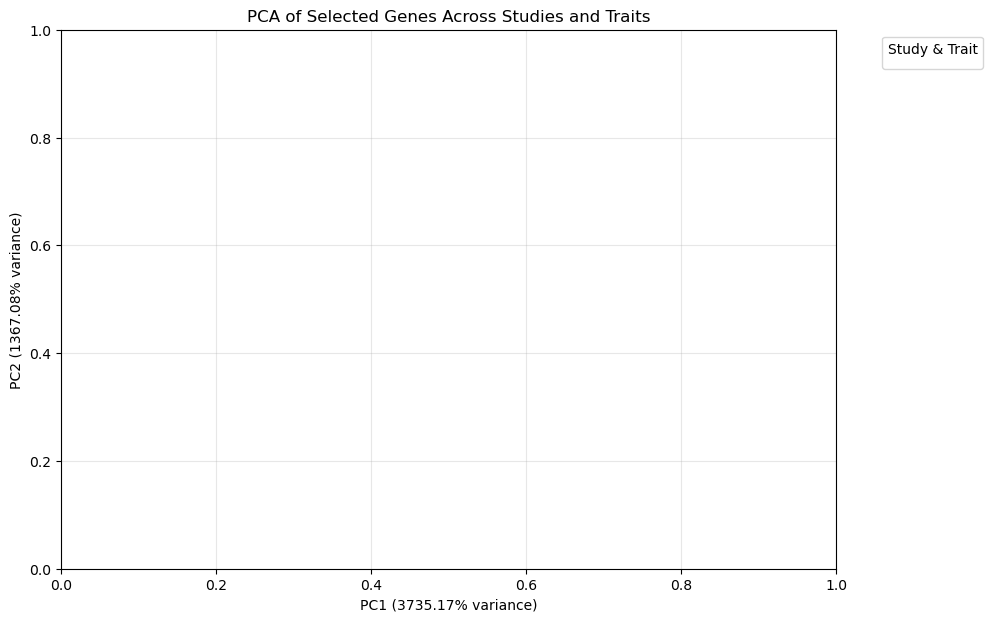

Max off-diagonal covariance: 1.0092344907925148
Smallest eigenvalue: (-1.3390110939820704e-14+0j)
Largest eigenvalue: (424.4746555494661+0j)
Sum of all eigenvalues: (1136.425925925927+2.465190328815662e-31j)
Variance explained by PC1: 37.35%
Variance explained by PC2: 13.67%
Sum of explained variance ratios: 0.5102
Rank of expression matrix: 108 (Expected: close to 1126)


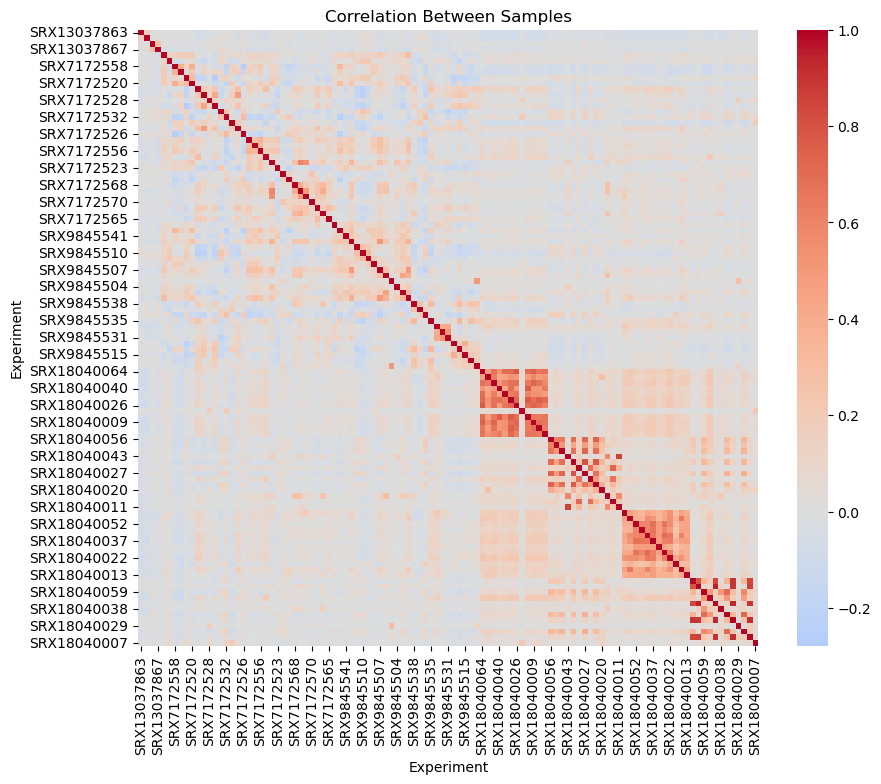

Unique rows in standardized_differences: 26077
Shape of PCA data: (0, 5)
Number of unique samples in PCA data: 5


In [12]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


missing_genes = set(final_selected_genes.index) - set(standardized_differences.index)
print(f"Genes in final_selected_genes but missing from standardized_differences: {len(missing_genes)}")
nan_gene_counts = standardized_differences.loc[final_selected_genes.index].isna().all(axis=1).sum()
print(f"Genes with all NaN values: {nan_gene_counts}")
print(f"Number of samples before filtering: {standardized_differences.shape[1]}")

# Extract expression values for the selected genes
top_gene_differences = standardized_differences.loc[final_selected_genes.index].dropna(axis=1, how="all")
# Store the original sample index before transformation
sample_index = top_gene_differences.T.index

# Transpose to have samples as rows and genes as columns
expression_matrix = top_gene_differences.T

# Handle missing or infinite values
expression_matrix = expression_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

# Standardize the data (optional but recommended for PCA)
scaler = StandardScaler()
expression_matrix = scaler.fit_transform(expression_matrix)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
expression_matrix = scaler.fit_transform(expression_matrix)

# Diagnostics for blank PCA
print(f"Expression matrix shape: {expression_matrix.shape} (expected: (samples, genes))")
print(f"Expression matrix min: {expression_matrix.min()}, max: {expression_matrix.max()}")
print("Variance per gene (mean ± std):", expression_matrix.var(axis=0).mean(), "±", expression_matrix.var(axis=0).std())
print("Max absolute value in matrix:", np.max(np.abs(expression_matrix)))
print(f"After scaling: mean = {expression_matrix.mean():.6f}, std = {expression_matrix.std():.6f}")

# Perform PCA
pca = PCA(n_components=2)  # Adjust number of components as needed
pca_results = pca.fit_transform(expression_matrix)


# Convert PCA results into a DataFrame
pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2"], index=sample_index)

# Retrieve sample metadata for labeling
pca_df = pca_df.merge(filtered_metadata[["Study", "BREED", "Trait"]], left_index=True, right_index=True)

# Assign colors by Study and markers by trait
study_palette = sns.color_palette("tab10", n_colors=pca_df["Study"].nunique())
study_colors = dict(zip(pca_df["Study"].unique(), study_palette))

# Define marker types
marker_dict = {"sensitive": "X", "tolerant": "o"}

# Plot PCA results
plt.figure(figsize=(10, 7))
for trait, marker in marker_dict.items():
    subset = pca_df[pca_df["Trait"] == trait]
    sns.scatterplot(
        x="PC1", y="PC2", hue="Study", style="Trait", markers=marker_dict,
        palette=study_colors, data=subset, edgecolor="black", s=100, alpha=0.8
    )

# Add variance explained to axis labels
explained_variance = pca.explained_variance_ratio_ * 100
plt.xlabel(f"PC1 ({explained_variance[0] * 100:.2f}% variance)")
plt.ylabel(f"PC2 ({explained_variance[1] * 100:.2f}% variance)")

# Customize legend
plt.legend(title="Study & Trait", bbox_to_anchor=(1.05, 1), loc="upper left")

# Title and grid
plt.title("PCA of Selected Genes Across Studies and Traits")
plt.grid(alpha=0.3)

# Show plot
plt.show()

# --- Diagnostics for blank PCA

import numpy as np
from sklearn.decomposition import PCA

# Compute the covariance matrix of the PCA input
cov_matrix = np.cov(expression_matrix, rowvar=False)

# 1️⃣ Check off-diagonal covariance values
max_off_diag = np.max(np.abs(cov_matrix - np.diag(np.diagonal(cov_matrix))))
print(f"Max off-diagonal covariance: {max_off_diag}")

# 2️⃣ Check eigenvalues to detect rank deficiency or instability
eigenvalues = np.linalg.eigvals(cov_matrix)
print(f"Smallest eigenvalue: {np.min(eigenvalues)}")
print(f"Largest eigenvalue: {np.max(eigenvalues)}")
print(f"Sum of all eigenvalues: {np.sum(eigenvalues)}")

# 3️⃣ Check if PCA variance is properly normalized
pca = PCA(n_components=2)
pca_results = pca.fit_transform(expression_matrix)
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {explained_variance[0] * 100:.2f}%")
print(f"Variance explained by PC2: {explained_variance[1] * 100:.2f}%")
print(f"Sum of explained variance ratios: {np.sum(explained_variance):.4f}")

# 4️⃣ Check if PCA input matrix has a rank deficiency
matrix_rank = np.linalg.matrix_rank(expression_matrix)
print(f"Rank of expression matrix: {matrix_rank} (Expected: close to {expression_matrix.shape[1]})")

# 5️⃣ Reduce the number of genes to check PCA stability
top_variance_genes = np.var(expression_matrix, axis=0).argsort()[-500:]  # Keep 500 most variable genes
expression_matrix_reduced = expression_matrix[:, top_variance_genes]


"""
# Create DataFrame for visualization
pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2"], index=final_selected_genes.columns)
pca_df = pca_df.join(filtered_metadata.set_index("Experiment"))

# Plot PCA colored by Study
plt.figure(figsize=(10, 6))
for study in pca_df["Study"].unique():
    subset = pca_df[pca_df["Study"] == study]
    plt.scatter(subset["PC1"], subset["PC2"], label=study, alpha=0.7)

# Update axis labels to include variance explained
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title("PCA of Selected Genes (Consistent Across Studies)")

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Study")
plt.grid(True)
plt.show()
"""

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(standardized_differences.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Between Samples")
plt.show()
print(f"Unique rows in standardized_differences: {len(set(map(tuple, standardized_differences.values)))}")
print(f"Shape of PCA data: {pca_df.shape}")  # Should be (n_samples, n_components)
print(f"Number of unique samples in PCA data: {len(set(map(tuple, pca_df)))}")
